## Regular Season Win Prediction

In [ ]:
import sys
import json
import pandas as pd

# Load datasets
games = pd.read_csv("games-full.csv", dtype={'game_id': str})
player_stats = pd.read_csv("player_game_stats-full-fixed.csv", dtype={'game_id': str})

# Filter for regular season games only
games = games[games["game_id"].str.startswith("002")]
player_stats = player_stats[player_stats["game_id"].str.startswith("002")]

# Melt games dataframe for team-wise games played
games_melted = games.melt(id_vars=["game_id", "season_year"], 
                          value_vars=["home_team_id", "away_team_id"],
                          value_name="team_id")

# Count games played per team per season
games_played = games_melted.groupby(["season_year", "team_id"])["game_id"].nunique().reset_index()
games_played.rename(columns={"game_id": "games_played"}, inplace=True)

# Parse nested player stats
player_stats['player_game_stats'] = player_stats['player_game_stats'].apply(json.loads)
player_stats = player_stats.dropna(subset=['player_game_stats']).copy()
player_stats = pd.concat(
    [player_stats.drop(columns=['player_game_stats']), 
     player_stats['player_game_stats'].apply(pd.Series)], 
    axis=1
)

# Merge season info
player_stats = player_stats.merge(games[['game_id', 'season_year']], on='game_id', how='left')

# Define stat columns
stats_columns = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 
                 'OREB', 'DREB', 'AST', 'STL', 'BLK', 
                 'TO', 'PTS']

# Filter and aggregate player stats
player_stats = player_stats[['season_year', 'game_id', 'team_id'] + stats_columns]
team_stats = player_stats.groupby(['game_id', 'team_id'])[stats_columns].sum().reset_index()

# Merge with games to determine home/away teams
team_stats = team_stats.merge(
    games[['game_id', 'season_year', 'home_team_id', 'away_team_id']], 
    on='game_id', 
    how='left'
)

# Separate home and away stats
home_stats = team_stats[team_stats['team_id'] == team_stats['home_team_id']]
away_stats = team_stats[team_stats['team_id'] == team_stats['away_team_id']]

# Rename columns
home_stats = home_stats.rename(columns={col: col + "_home" for col in stats_columns}).drop(columns=['team_id'])
away_stats = away_stats.rename(columns={col: col + "_away" for col in stats_columns}).drop(columns=['team_id'])

# Merge into one row per game
game_stats = home_stats.merge(away_stats, on=['game_id', 'season_year', 'home_team_id', 'away_team_id'], how='inner')

# Compute outcome, 1 if home team wins, 0 otherwise
game_stats["home_team_win"] = (game_stats["PTS_home"] > game_stats["PTS_away"]).astype(int)

# Create a dataframe of winners
winners = pd.DataFrame({
    "game_id": game_stats["game_id"],
    "winner_team_id": game_stats["home_team_id"].where(game_stats["home_team_win"] == 1, game_stats["away_team_id"])
})

# Convert to long format for modeling
home_team_stats = game_stats[["game_id", "season_year", "home_team_id"] + [col for col in game_stats.columns if col.endswith("_home")]].copy()
away_team_stats = game_stats[["game_id", "season_year", "away_team_id"] + [col for col in game_stats.columns if col.endswith("_away")]].copy()

home_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_home", "") for col in home_team_stats.columns[3:]]
away_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_away", "") for col in away_team_stats.columns[3:]]

long_stats = pd.concat([home_team_stats, away_team_stats], axis=0).sort_values(["team_id", "season_year", "game_id"])

# Sort by game_date in chonological order before calculating rolling averages
long_stats = long_stats.merge(games[['game_id', 'game_date']], on='game_id', how='left')
long_stats = long_stats.sort_values('game_date').reset_index(drop=True)

wl_count = long_stats.copy()

# Merge the winner lookup table into the long stats df
wl_count = wl_count.merge(winners, on='game_id', how='left')

# Calculate wins and losses for each team up to the current game
wl_count["won_game"] = (wl_count["team_id"] == wl_count["winner_team_id"]).astype(int)
wl_count["games_so_far"] = (
    wl_count.groupby(['team_id', 'season_year'])
    .cumcount()
)
wl_count["wins"] = (
    wl_count.groupby(['team_id', 'season_year'])["won_game"]
    .cumsum() - wl_count["won_game"]
).fillna(0).astype(int)
wl_count["losses"] = (
    wl_count["games_so_far"] - wl_count["wins"]
).clip(lower=0).astype(int)

wl_count.to_csv("long_stats.csv", index=False)

# Compute number of possessions for each team (from NBA.com)
long_stats["POSS"] = (
    (long_stats["FGA"] + 0.44 * long_stats["FTA"] - long_stats["OREB"] + long_stats["TO"])
)
long_stats["POSS"] = long_stats["POSS"].clip(lower=0)  # Ensure there are no negative possession values

# Compute per 100 possession stats
per_100_columns = [stat + "_100" for stat in stats_columns]
for stat in stats_columns:
    long_stats[stat + "_100"] = 100 * long_stats[stat] / long_stats["POSS"]

# Add the possession stat to per_100_columns so we can compute rolling averages for it
per_100_columns.append("POSS")

# Compute rolling averages of per-100-possession stats
def compute_rolling_averages(group):
    return group[per_100_columns].shift().expanding().mean()

long_stats_avg = long_stats.copy()
long_stats_avg[per_100_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)
long_stats_avg.drop(columns=stats_columns, inplace=True)

# Fallback: previous season average per-100 stats
prev_season_averages = long_stats.groupby(["team_id", "season_year"])[per_100_columns].mean().reset_index()

def shift_season(season_str):
    start, end = season_str.split("-")
    next_start = str(int(start) + 1)
    next_end = str(int(end[-2:]) + 1).zfill(2)
    return f"{next_start}-{next_end}"

prev_season_averages["season_year"] = prev_season_averages["season_year"].apply(shift_season)

long_stats_avg = long_stats_avg.merge(
    prev_season_averages,
    on=["team_id", "season_year"],
    how="left",
    suffixes=("", "_fallback")
)

for stat in per_100_columns:
    long_stats_avg[stat] = long_stats_avg[stat].fillna(long_stats_avg[f"{stat}_fallback"])
    long_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

long_stats_avg.dropna(inplace=True)

# Compute opponent average allowed stats
opponent_stats = long_stats[["game_id", "team_id"] + per_100_columns].copy()
opponent_stats = opponent_stats.rename(columns={col: col + "_opp" for col in per_100_columns})
team_opponent_stats = long_stats[["game_id", "team_id", "season_year"]].merge(
    opponent_stats, on="game_id", suffixes=("", "_opp"))
team_opponent_stats = team_opponent_stats[team_opponent_stats["team_id"] != team_opponent_stats["team_id_opp"]]

# Rolling average of allowed stats
opp_stat_cols = [stat + "_opp" for stat in per_100_columns]
team_opponent_stats_avg = team_opponent_stats.copy()
team_opponent_stats_avg[opp_stat_cols] = team_opponent_stats.groupby(["team_id", "season_year"], group_keys=False)[opp_stat_cols].apply(lambda g: g.shift().expanding().mean())

# Fallback from previous season
prev_opp_season_averages = team_opponent_stats.groupby(["team_id", "season_year"])[opp_stat_cols].mean().reset_index()
prev_opp_season_averages["season_year"] = prev_opp_season_averages["season_year"].apply(shift_season)

team_opponent_stats_avg = team_opponent_stats_avg.merge(
    prev_opp_season_averages,
    on=["team_id", "season_year"],
    how="left",
    suffixes=("", "_fallback")
)

for stat in opp_stat_cols:
    team_opponent_stats_avg[stat] = team_opponent_stats_avg[stat].fillna(team_opponent_stats_avg[f"{stat}_fallback"])
    team_opponent_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

team_opponent_stats_avg.dropna(inplace=True)

# Home/Away features
home_features = long_stats_avg.merge(game_stats[['game_id', 'home_team_id']], left_on=['game_id', 'team_id'], right_on=['game_id', 'home_team_id'], how='inner').drop(columns=['home_team_id'])
away_features = long_stats_avg.merge(game_stats[['game_id', 'away_team_id']], left_on=['game_id', 'team_id'], right_on=['game_id', 'away_team_id'], how='inner').drop(columns=['away_team_id'])

# Add wins and losses to home and away features
home_features = home_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=['game_id', 'team_id'], how='left')
away_features = away_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=['game_id', 'team_id'], how='left')

# Rename the columns for home and away features
home_features = home_features.rename(columns={stat: f"{stat}_home" for stat in per_100_columns} | {'wins': 'home_wins', 'losses': 'home_losses'})
away_features = away_features.rename(columns={stat: f"{stat}_away" for stat in per_100_columns} | {'wins': 'away_wins', 'losses': 'away_losses'})

# Merge features
ml_df = home_features.merge(away_features, on=["game_id", "game_date"], how="inner").merge(
    game_stats[["game_id", "home_team_win"]],
    on="game_id", how="inner"
)
ml_df = ml_df.drop_duplicates('game_id')

# Clean up
ml_df = ml_df.drop(columns=["team_id_x", "team_id_y", "season_year_x", "season_year_y", "game_date"], errors='ignore')
X = ml_df.drop(columns=["game_id", "home_team_win"])
y = ml_df["home_team_win"]

X.head(), y.head()
# Save the final DataFrame to a CSV file
ml_df.to_csv("ml_features.csv", index=False)
# Save the features and target variable separately
X.to_csv("X_features.csv", index=False)
y.to_csv("y_target.csv", index=False)

C:\Users\trito\AppData\Local\Temp\ipykernel_16000\1001932974.py:123: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_stats_avg[per_100_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)


Accuracy: 0.645
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.46      0.55       757
           1       0.63      0.80      0.71       871

    accuracy                           0.64      1628
   macro avg       0.65      0.63      0.63      1628
weighted avg       0.65      0.64      0.63      1628



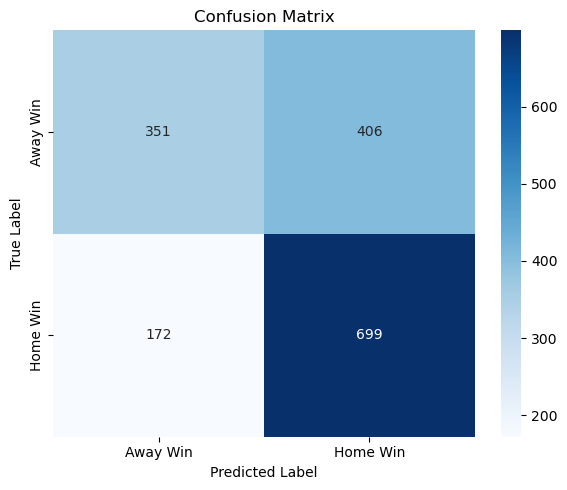

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=80, shuffle=False)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

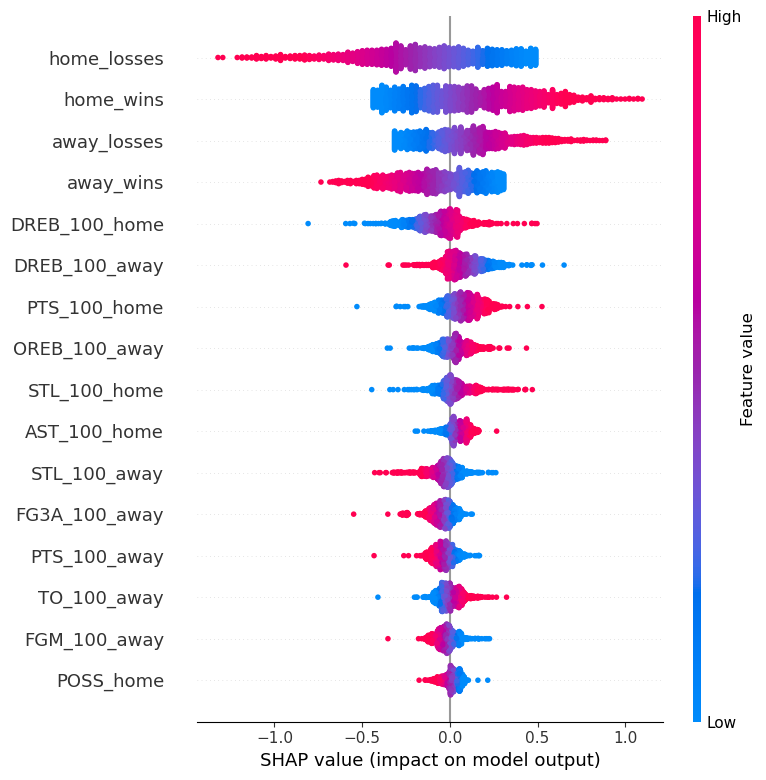

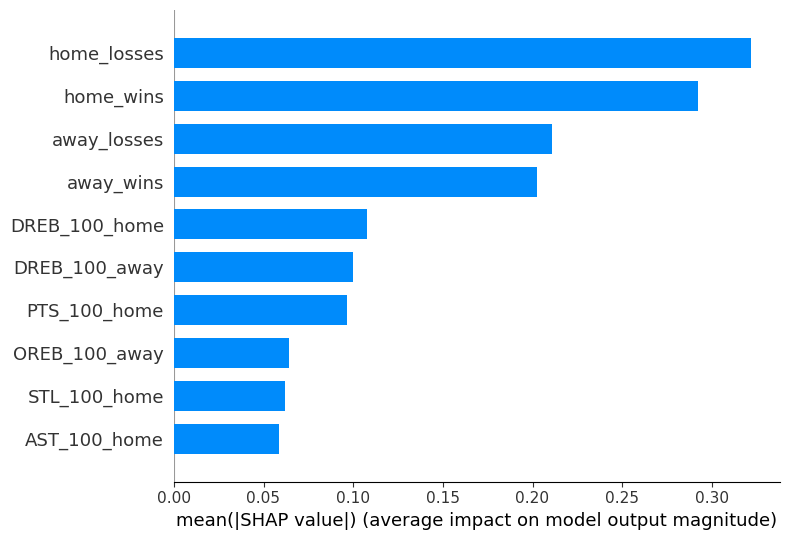

In [ ]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=16)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=10, plot_type="bar")

Accuracy: 0.6296
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.39      0.50       757
           1       0.61      0.83      0.71       871

    accuracy                           0.63      1628
   macro avg       0.64      0.61      0.60      1628
weighted avg       0.64      0.63      0.61      1628



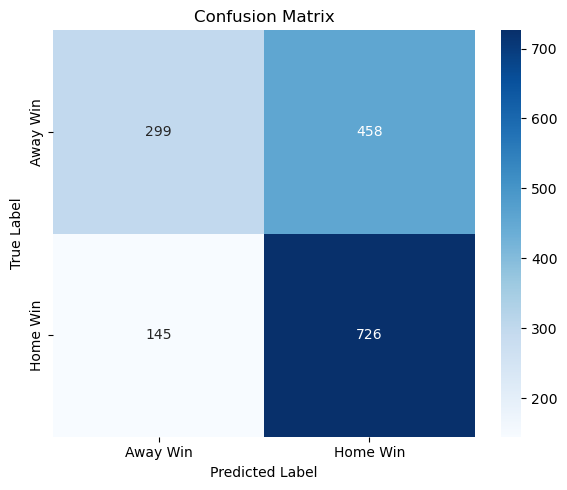

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=80, shuffle=False)

model = RandomForestClassifier(
    max_depth = 26, 
    max_features = 'sqrt', 
    min_samples_leaf = 18, 
    min_samples_split = 13, 
    n_estimators = 211
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(5, 30),         
    'min_samples_split': randint(2, 20),      
    'min_samples_leaf': randint(1, 20),     
    'max_features': ['sqrt', 'log2', None]   
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5, 
    verbose=1,
    random_state=42,
    n_jobs=1,                 
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 18, 'min_samples_split': 13, 'n_estimators': 211}
Best Accuracy: 0.6069124423963134
